In [42]:
import pandas as pd
import sys
sys.path.append("../src/utils")
from utils import read_raw_network_data

## Reading data ##

In [43]:
trafo_id = "T1330" #T1330 T0932
data, _ = read_raw_network_data(trafo_id, depth=1)

In [44]:
data["nodes_static_data"].head()

,aclass_id,bus,smm,prikljucna_moc_odjem,prikljucna_moc_oddaja,x_y,lon_lat
0,junction,97327,NaN,NaN,NaN,"(530588.0843000002, 153821.05189999938)","(21.48883237280564, 49.25298769476685)"
1,PMO,55363,110471.0,35.0,0.0,"(530715.1489000004, 154094.69480000064)","(21.490457517273, 49.25545698477883)"
2,PMO,55364,91558.0,17.0,14.0,"(530714.4113999996, 153845.96270000003)","(21.49046867801605, 49.25321912788421)"
3,PMO,55367,30234.0,14.0,0.0,"(530699.8213, 153848.67300000042)","(21.490279227137176, 49.253242668676066)"
4,PMO,55368,30233.0,14.0,0.0,"(530683.6710999999, 153849.89320000075)","(21.49006966676341, 49.25325271264873)"


In [45]:
data.keys()

dict_keys(['lines_static_data', 'nodes_static_data', 'SMM_measurements', 'TP_measurements'])

In [46]:
data_nodes = data["nodes_static_data"]
data_edges = data["lines_static_data"]
data_ts_smm = data["SMM_measurements"]
data_ts_tp = data["TP_measurements"]

In [47]:
data_ts_smm.head()

,SMM,trafo_station_id,active_energy,active_power,reactive_energy,reactive_power,date_time,trafo_id,current,voltage,temperature_2m,snow_depth,cloud_cover,is_day,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance
0,91598,2063,0.034,0.136,0.0,0.0,2021-06-01 03:15:00,440,NaN,231.900000,11.701500,0.0,19.050000,0.0,3.5,1.00,2.50,11.289428
1,91598,2063,0.135,0.540,0.0,0.0,2021-06-01 07:45:00,440,NaN,231.566667,15.964000,0.0,14.250001,1.0,540.5,392.75,147.75,623.158400
2,91598,2063,0.027,0.108,0.0,0.0,2021-06-01 23:30:00,440,NaN,232.633333,13.401501,0.0,15.599998,0.0,0.0,0.00,0.00,0.000000
3,91598,2063,0.135,0.540,0.0,0.0,2021-06-01 06:30:00,440,NaN,232.316667,14.226500,0.0,9.150000,1.0,330.0,224.00,106.00,514.942200
4,91598,2063,0.135,0.540,0.0,0.0,2021-06-01 07:30:00,440,NaN,233.683333,15.601500,0.0,10.800000,1.0,491.0,350.50,140.50,587.436900


In [48]:
data_ts_tp.head()

,trafo_id,trafo_station_id,date_time,active_power,reactive_power,voltage,current
0,440,2063,2021-06-01 05:30:00,168500,43800,231.580000,250.633333
1,440,2063,2021-06-01 03:10:00,124300,21500,231.840000,181.400000
2,440,2063,2021-06-01 21:05:00,257600,46600,233.090000,374.433333
3,440,2063,2021-06-01 10:35:00,238400,43700,230.546667,350.500000
4,440,2063,2021-06-01 04:55:00,143200,30200,231.826667,210.533333


## Preprocessing ##

### Node preprocessing ###

In [49]:
def aggr_by_bus_aclassid(data_nodes_proc):
    """
    Aggregates nodes by bus and aclass_id and returns a dataframe with the aggregated data.
    """

    #copy of code from 02-kk-create-nx.ipynb
    data_nodes_aggr = data_nodes_proc.groupby(["bus", "aclass_id"]).agg(list)
    data_nodes_aggr = data_nodes_aggr.rename(columns={"smm": "smm_list"})
    data_nodes_aggr["x_y"] = data_nodes_aggr["x_y"].apply(lambda x: x[0])
    data_nodes_aggr["lon_lat"] = data_nodes_aggr["lon_lat"].apply(lambda x: x[0])
    data_nodes_aggr = data_nodes_aggr.reset_index()
    
    #dictionaries for mapping from bus and smm_list to nodeid
    dict_of_bus_to_nodeid = dict(zip(data_nodes_aggr["bus"].tolist(), range(len(data_nodes_aggr))))
    dict_of_smms_to_nodeid =  { x: i for i, y in enumerate(data_nodes_aggr["smm_list"].tolist()) if (y!= None) for x in y }
    
    #map bus to node_id
    data_nodes_aggr.insert(0, "node_id", range(len(data_nodes_aggr)))
    data_nodes_aggr["node_id"] = data_nodes_aggr["bus"].apply(lambda x: dict_of_bus_to_nodeid[x])
    
    #aggregate prikljucna_moc_odjem to prikljucna_moc_odjem_aggr
    data_nodes_aggr.insert(5, "prikljucna_moc_odjem_aggr", data_nodes_aggr["prikljucna_moc_odjem"].apply(sum))
    
    #aggregate prikljucna_moc_oddaja to prikljucna_moc_oddaja_aggr
    data_nodes_aggr.insert(7, "prikljucna_moc_oddaja_aggr", data_nodes_aggr["prikljucna_moc_oddaja"].apply(sum))
    
    data_nodes_aggr = data_nodes_aggr.drop(columns=["bus"])
    
    return data_nodes_aggr, dict_of_bus_to_nodeid, dict_of_smms_to_nodeid

In [50]:
data_test, dict_bus2nodeid_test, dict_smms2nodeid_test = aggr_by_bus_aclassid(data_nodes)
data_test[20:25]

,node_id,aclass_id,smm_list,prikljucna_moc_odjem,prikljucna_moc_odjem_aggr,prikljucna_moc_oddaja,prikljucna_moc_oddaja_aggr,x_y,lon_lat
20,20,PMO,"[114592.0, 114593.0, 114596.0]","[14.0, 14.0, 14.0]",42.0,"[0.0, 0.0, 0.0]",0.0,"(530617.4486999996, 154130.01669999957)","(21.489187401360354, 49.25576911726745)"
21,21,PMO,[122711.0],[17.0],17.0,[0.0],0.0,"(530610.9187000003, 154131.54690000042)","(21.489102579360633, 49.25578250586195)"
22,22,PMO,[115604.0],[14.0],14.0,[11.0],11.0,"(530610.7186000003, 154130.61690000072)","(21.489100061766038, 49.25577412716477)"
23,23,PMO,"[115194.0, 115545.0, 115544.0]","[14.0, 14.0, 14.0]",42.0,"[0.0, 0.0, 0.0]",0.0,"(530608.8373999996, 154088.81650000066)","(21.489079155274773, 49.255397944875156)"
24,24,PMO,[115328.0],[14.0],14.0,[0.0],0.0,"(530604.1573999999, 154090.62659999914)","(21.48901830478941, 49.25541395886137)"


In [51]:
# dict_bus2nodeid_test[2063]

In [52]:
data["nodes_static_data"].query("bus == 2063")

,aclass_id,bus,smm,prikljucna_moc_odjem,prikljucna_moc_oddaja,x_y,lon_lat


In [53]:
# data_test[[dict_smms2nodeid[tuple(x)] for x in data_test["smm_list"]] != data_test["node_id"]]

In [54]:
def preprocess_nodes(data_nodes_proc):
    """
    Preprocesses nodes data and returns a dataframe with the aggregated data and dictionaries for mapping from bus and smm_list to nodeid.
    """
    
    data_nodes_proc, dict_bus2nodeid, dict_smms2nodeid = aggr_by_bus_aclassid(data_nodes_proc)
    
    return data_nodes_proc, dict_bus2nodeid, dict_smms2nodeid

### Preprocessing edges ###

In [55]:
def preprocess_edges(data_edges_proc, dict_bus2nodeid):
    
    return data_edges_proc

### Preprocessing tp timeseries ###

In [56]:
def preprocess_ts_tp(data_ts_tp_proc, dict_bus2nodeid):
    
    return data_ts_tp_proc

### Preprocessing smm timeseries ###

In [57]:
def map_ts_smm(data_ts_smm_proc, dict_smms2nodeid, dict_bus2nodeid):
    
    # print(type(data_ts_smm_proc["SMM"]))
    
    data_ts_smm_proc.insert(0, "node_id", range(len(data_ts_smm_proc)))

    data_ts_smm_proc_smm = data_ts_smm_proc["SMM"].map(lambda x: dict_smms2nodeid[x])
    data_ts_smm_proc = data_ts_smm_proc.drop(columns=["SMM"])
    
    # data_ts_smm_proc.insert(0, "trafo_station_node_id", range(len(data_ts_smm_proc)))
    # data_ts_smm_proc["trafo_station_node_id"] = data_ts_smm_proc["trafo_station_id"].map(lambda x: dict_bus2nodeid[x])
    
    return data_ts_smm_proc

In [58]:
def preprocess_ts_smm(data_ts_smm_proc, dict_smms2nodeid, dict_bus2nodeid):
    
    data_ts_smm_proc = map_ts_smm(data_ts_smm_proc, dict_smms2nodeid, dict_bus2nodeid)
    
    return data_ts_smm_proc

### Puting preprocessing together ###

In [59]:
def preprocess(data_preprocess):
    """
    Preprocesses the data.
    """
    data_preprocessed = data_preprocess.copy()
    data_nodes_proc = data_preprocessed["nodes_static_data"]
    data_edges_proc = data_preprocessed["lines_static_data"]
    data_ts_smm_proc = data_preprocessed["SMM_measurements"]
    data_ts_tp_proc = data_preprocessed["TP_measurements"]
    
    data_nodes_proc, dict_bus2nodeid, dict_smms2nodeid = preprocess_nodes(data_nodes_proc)
    data_edges_proc = preprocess_edges(data_edges_proc, dict_bus2nodeid)
    data_ts_smm_proc = preprocess_ts_smm(data_ts_smm_proc, dict_smms2nodeid, dict_bus2nodeid)
    data_ts_tp_proc = preprocess_ts_tp(data_ts_tp_proc, dict_bus2nodeid)
    
    data_preprocessed["nodes_static_data"] = data_nodes_proc
    data_preprocessed["lines_static_data"] = data_edges_proc
    data_preprocessed["SMM_measurements"] = data_ts_smm_proc
    data_preprocessed["TP_measurements"] = data_ts_tp_proc
    
    return data_preprocessed, dict_bus2nodeid, dict_smms2nodeid
    

In [60]:
data_test = data.copy()
data_test, dict_bus2nodeid_test, dict_smms2nodeid_test = preprocess(data_test)
data_test["nodes_static_data"][20:25]
data_test["SMM_measurements"].head()

,node_id,trafo_station_id,active_energy,active_power,reactive_energy,reactive_power,date_time,trafo_id,current,voltage,temperature_2m,snow_depth,cloud_cover,is_day,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance
0,0,2063,0.034,0.136,0.0,0.0,2021-06-01 03:15:00,440,NaN,231.900000,11.701500,0.0,19.050000,0.0,3.5,1.00,2.50,11.289428
1,1,2063,0.135,0.540,0.0,0.0,2021-06-01 07:45:00,440,NaN,231.566667,15.964000,0.0,14.250001,1.0,540.5,392.75,147.75,623.158400
2,2,2063,0.027,0.108,0.0,0.0,2021-06-01 23:30:00,440,NaN,232.633333,13.401501,0.0,15.599998,0.0,0.0,0.00,0.00,0.000000
3,3,2063,0.135,0.540,0.0,0.0,2021-06-01 06:30:00,440,NaN,232.316667,14.226500,0.0,9.150000,1.0,330.0,224.00,106.00,514.942200
4,4,2063,0.135,0.540,0.0,0.0,2021-06-01 07:30:00,440,NaN,233.683333,15.601500,0.0,10.800000,1.0,491.0,350.50,140.50,587.436900


In [ ]:
data_ts_smm.query("trafo_station_id == 2063")

,trafo_station_node_id,node_id,SMM,trafo_station_id,active_energy,active_power,reactive_energy,reactive_power,date_time,trafo_id,current,voltage,temperature_2m,snow_depth,cloud_cover,is_day,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance
0,0,52,91598,2063,0.034,0.136,0.0,0.0,2021-06-01 03:15:00,440,NaN,231.900000,11.701500,0.0,19.050000,0.0,3.50,1.00,2.50,11.289428
1,1,52,91598,2063,0.135,0.540,0.0,0.0,2021-06-01 07:45:00,440,NaN,231.566667,15.964000,0.0,14.250001,1.0,540.50,392.75,147.75,623.158400
2,2,52,91598,2063,0.027,0.108,0.0,0.0,2021-06-01 23:30:00,440,NaN,232.633333,13.401501,0.0,15.599998,0.0,0.00,0.00,0.00,0.000000
3,3,52,91598,2063,0.135,0.540,0.0,0.0,2021-06-01 06:30:00,440,NaN,232.316667,14.226500,0.0,9.150000,1.0,330.00,224.00,106.00,514.942200
4,4,52,91598,2063,0.135,0.540,0.0,0.0,2021-06-01 07:30:00,440,NaN,233.683333,15.601500,0.0,10.800000,1.0,491.00,350.50,140.50,587.436900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8575980,8575980,22,115604,2063,0.004,0.016,0.0,0.0,2023-06-01 20:00:00,440,NaN,230.966667,19.480999,0.0,27.600000,0.0,0.00,0.00,0.00,0.000000
8575981,8575981,9,91558,2063,-0.177,-0.708,0.0,0.0,2023-06-01 17:00:00,440,NaN,229.933333,20.626500,0.0,50.400000,1.0,184.00,90.00,94.00,253.018700
8575982,8575982,22,115604,2063,-0.419,-1.676,0.0,0.0,2023-06-01 08:15:00,440,NaN,232.733333,20.105999,0.0,10.800000,1.0,624.00,490.00,134.00,709.698700
8575983,8575983,22,115604,2063,-0.715,-2.860,0.0,0.0,2023-06-01 14:00:00,440,NaN,231.466667,22.431000,0.0,42.600000,1.0,596.00,427.00,169.00,548.066960


In [61]:
data["SMM_measurements"].head()

,node_id,SMM,trafo_station_id,active_energy,active_power,reactive_energy,reactive_power,date_time,trafo_id,current,voltage,temperature_2m,snow_depth,cloud_cover,is_day,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance
0,0,91598,2063,0.034,0.136,0.0,0.0,2021-06-01 03:15:00,440,NaN,231.900000,11.701500,0.0,19.050000,0.0,3.5,1.00,2.50,11.289428
1,1,91598,2063,0.135,0.540,0.0,0.0,2021-06-01 07:45:00,440,NaN,231.566667,15.964000,0.0,14.250001,1.0,540.5,392.75,147.75,623.158400
2,2,91598,2063,0.027,0.108,0.0,0.0,2021-06-01 23:30:00,440,NaN,232.633333,13.401501,0.0,15.599998,0.0,0.0,0.00,0.00,0.000000
3,3,91598,2063,0.135,0.540,0.0,0.0,2021-06-01 06:30:00,440,NaN,232.316667,14.226500,0.0,9.150000,1.0,330.0,224.00,106.00,514.942200
4,4,91598,2063,0.135,0.540,0.0,0.0,2021-06-01 07:30:00,440,NaN,233.683333,15.601500,0.0,10.800000,1.0,491.0,350.50,140.50,587.436900


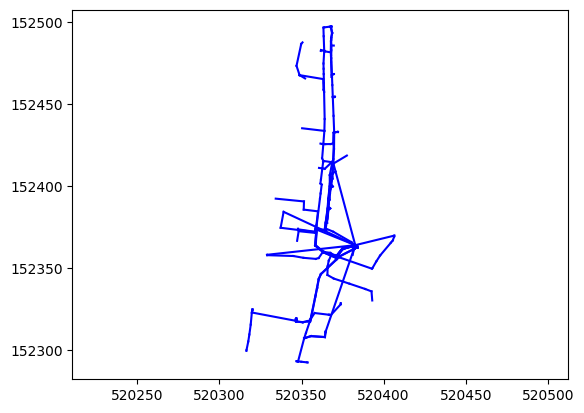

In [ ]:
import matplotlib.pyplot as plt

for row in data_edges.iterrows():
    coords = row[1]["coords"]
    #transform string to list of tuples
    coords = eval(coords)
    for i in range(len(coords)-1):
        x0, y0 = coords[i]
        x1, y1 = coords[i+1]
        plt.plot([x0, x1], [y0, y1], "b")
#show plot with equal axis dimensions
plt.axis("equal")
plt.show()